The client initially wants the application to perform the following actions on the data:
1.	Outputs should not include any data from vendors that have a ‘PROGRAM STATUS’ of INACTIVE.
2.	The ‘PE DESCRIPTION’ column contains information on the number and type of seating available at the vendor. Extract this out into a new column, retain all other information within that column. E.g.: 
    a.	‘FOOD MKT RETAIL (1-1,999 SF) LOW RISK’, 
    b.	‘RESTAURANT (61-150) SEATS LOW RISK’.  
    c.	Extract the greyed area out and retain the rest in the examples
3.	The client initially needs information to generate the following and output the results using appropriate representation:
    a.	Produce the mean, mode and median for the inspection score per year:
        i.	For each type of vendor’s seating
        ii.	For each ‘zip code’
4.	Produce a suitable graph that displays the number of establishments that have committed each type of violation. You may need to consider how you group this data to make visualisation feasible
5.	Determine if there is any significant correlation between the number of violations committed per vendor and their zip code, ‘Is there a tendency for facilities in specific locations to have more violations?’. You will need to select an appropriate visualisation to demonstrate this.


In [94]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import warnings
from scipy import stats
warnings.filterwarnings('ignore')
%matplotlib inline

## Loading the dataets

In [95]:
insp = pd.read_csv('Inspections.csv')
inv = pd.read_csv('Inventory.csv')
viol = pd.read_csv('violations.csv')

In [96]:
print(insp.shape)
print(inv.shape)
print(viol.shape)

(206461, 25)
(40616, 23)
(954081, 5)


## Checking the features and data types of the datasets

In [97]:
print(insp.info())
print(inv.info())
print(viol.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206461 entries, 0 to 206460
Data columns (total 25 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   ACTIVITY DATE                                      206461 non-null  object 
 1   OWNER ID                                           206461 non-null  object 
 2   OWNER NAME                                         206461 non-null  object 
 3   FACILITY ID                                        206461 non-null  object 
 4   FACILITY NAME                                      206461 non-null  object 
 5   RECORD ID                                          206461 non-null  object 
 6   PROGRAM NAME                                       206461 non-null  object 
 7   PROGRAM STATUS                                     206461 non-null  object 
 8   PROGRAM ELEMENT (PE)                               206461 non-null  int64 

1. Dropping entries with 'PROGRAM STATUS' of 'INACTIVE'

In [98]:
insp = insp.drop(insp[insp['PROGRAM STATUS'] == 'INACTIVE'].index, inplace = False, axis=0)
insp.shape

(183867, 25)

## 2. Extracting Seating information into a new column. 

In [99]:
#extract all characters in parentheses into the new column

insp['PE DESCRIPTION NEW'] = insp['PE DESCRIPTION'].str.extract(r'\((.+)\)') 

In [100]:
#replace characters in parenthesis with an empty string

insp['PE DESCRIPTION'] = insp['PE DESCRIPTION'].str.replace(r'\((.+)\)', '') 

In [101]:
insp['PE DESCRIPTION'].head()

0    RESTAURANT  SEATS MODERATE RISK
1    RESTAURANT  SEATS MODERATE RISK
2    RESTAURANT  SEATS MODERATE RISK
3    RESTAURANT  SEATS MODERATE RISK
4        RESTAURANT  SEATS HIGH RISK
Name: PE DESCRIPTION, dtype: object

In [102]:
#new column with seating info

insp['PE DESCRIPTION NEW'].head() 

0    0-30
1    0-30
2    0-30
3    0-30
4    0-30
Name: PE DESCRIPTION NEW, dtype: object

In [103]:
insp.head()

,ACTIVITY DATE,OWNER ID,OWNER NAME,FACILITY ID,FACILITY NAME,RECORD ID,PROGRAM NAME,PROGRAM STATUS,PROGRAM ELEMENT (PE),PE DESCRIPTION,...,SCORE,GRADE,SERIAL NUMBER,EMPLOYEE ID,Location,2011 Supervisorial District Boundaries (Official),Census Tracts 2010,Board Approved Statistical Areas,Zip Codes,PE DESCRIPTION NEW
0,08/23/2018,OW0000809,31,FA0019645,DREAM DINNERS,PR0045642,DREAM DINNERS,ACTIVE,1631,RESTAURANT SEATS MODERATE RISK,...,97.0,A,DA2FXQNN6,EE0000126,POINT (-118.36927 33.826754),4.0,820.0,102.0,25719.0,0-30
1,12/06/2017,OW0000809,31,FA0019645,DREAM DINNERS,PR0045642,DREAM DINNERS,ACTIVE,1631,RESTAURANT SEATS MODERATE RISK,...,95.0,A,DACP43IQW,EE0000126,POINT (-118.36927 33.826754),4.0,820.0,102.0,25719.0,0-30
2,06/23/2017,OW0000809,31,FA0019645,DREAM DINNERS,PR0045642,DREAM DINNERS,ACTIVE,1631,RESTAURANT SEATS MODERATE RISK,...,96.0,A,DAEMVMRBY,EE0000126,POINT (-118.36927 33.826754),4.0,820.0,102.0,25719.0,0-30
3,03/19/2019,OW0000809,31,FA0019645,DREAM DINNERS,PR0045642,DREAM DINNERS,ACTIVE,1631,RESTAURANT SEATS MODERATE RISK,...,96.0,A,DANER68S4,EE0000126,POINT (-118.36927 33.826754),4.0,820.0,102.0,25719.0,0-30
4,03/01/2018,OW0000002,#1 CAFE INC,FA0056432,#1 CAFE,PR0045100,#1 CAFE,ACTIVE,1632,RESTAURANT SEATS HIGH RISK,...,90.0,A,DACZXQ74W,EE0000015,POINT (-118.412323 34.058815),3.0,660.0,265.0,24032.0,0-30


## Grouping Inspection Score by Year, Zip Codes and Seating Info

In [104]:
insp['ACTIVITY DATE'] = pd.to_datetime(insp['ACTIVITY DATE'])

In [105]:
#mean of inspecton score throughout the years

date_score_mean = pd.DataFrame(insp.groupby(insp['ACTIVITY DATE'].dt.year).mean()['SCORE'])
date_score_mean

,SCORE
ACTIVITY DATE,
2016,94.137656
2017,93.882464
2018,93.896916
2019,94.093889


In [106]:
#median of inspecton score throughout the years

date_score_median = pd.DataFrame(insp.groupby(insp['ACTIVITY DATE'].dt.year).median()['SCORE'])
date_score_median

,SCORE
ACTIVITY DATE,
2016,94.0
2017,94.0
2018,94.0
2019,95.0


In [107]:
#mean of inspection scores of the various codes

zip_score_mean = pd.DataFrame(insp.groupby(insp['Zip Codes']).mean()['SCORE'])
zip_score_mean.head()

,SCORE
Zip Codes,
2443.0,93.243137
2445.0,94.830721
2447.0,94.098335
2451.0,95.308000
2832.0,94.589286


In [108]:
#median of inspection scores by various zip codes

zip_score_median = pd.DataFrame(insp.groupby(insp['Zip Codes']).median()['SCORE'])
zip_score_median.head()

,SCORE
Zip Codes,
2443.0,94.0
2445.0,95.0
2447.0,95.0
2451.0,96.0
2832.0,95.0


In [109]:
#mean of inspection scores by seating info

seat_score_mean = pd.DataFrame(insp.groupby(insp['PE DESCRIPTION NEW']).mean()['SCORE'])
seat_score_mean.head()

,SCORE
PE DESCRIPTION NEW,
0-10,99.000000
0-1999 SF,98.714286
0-30,94.026432
0-999 SQ. FT.,95.678571
"1,000-1,999 SQ. FT.",92.952381


In [110]:
#median of inspection scores by seating info

seat_score_median = pd.DataFrame(insp.groupby(insp['PE DESCRIPTION NEW']).median()['SCORE'])
seat_score_median.head()

,SCORE
PE DESCRIPTION NEW,
0-10,100.0
0-1999 SF,99.0
0-30,95.0
0-999 SQ. FT.,96.5
"1,000-1,999 SQ. FT.",93.0


In [111]:
#seat_score_mode = pd.DataFrame(insp.groupby(insp['PE DESCRIPTION NEW']).mode()['SCORE'])
#seat_score_mode.head()

In [112]:
#seat_score_mode = insp.groupby(by=insp['PE DESCRIPTION NEW'])
#seat_score_mode.head()

In [113]:
stats.mode(insp['SCORE'])

ModeResult(mode=array([96.]), count=array([20966]))

## Exploring the violations committed by the various establishments

In [114]:
viol.head()

,SERIAL NUMBER,VIOLATION STATUS,VIOLATION CODE,VIOLATION DESCRIPTION,POINTS
0,DA0004KIJ,OUT OF COMPLIANCE,F049,# 50. Impoundment of unsanitary equipment or food,0
1,DA0004KIJ,OUT OF COMPLIANCE,F042,"# 42. Toilet facilities: properly constructed,...",1
2,DA0004KIJ,OUT OF COMPLIANCE,F037,# 37. Adequate ventilation and lighting; desig...,1
3,DA0004KIJ,OUT OF COMPLIANCE,F015,# 15. Food obtained from approved source,2
4,DA0004KIJ,OUT OF COMPLIANCE,F006,# 06. Adequate handwashing facilities supplied...,2


In [115]:
viol['VIOLATION  STATUS'].value_counts()

OUT OF COMPLIANCE       954076
VIOLATION                    4
HOUSING NON-CRITICAL         1
Name: VIOLATION  STATUS, dtype: int64

VIOLATION STATUS that occurs the most is OUT OF COMPLIANCE with 954076 entries. 

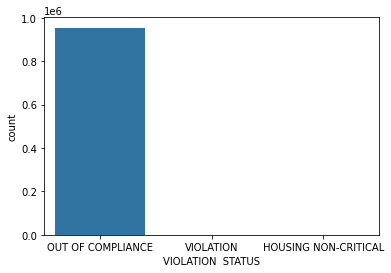

In [116]:
sns.countplot(x='VIOLATION  STATUS', data=viol)

In [117]:
viol['VIOLATION CODE'].nunique()

98

There are 98 unique objects in VIOLATION CODE. That means there are 98 different possible violations. With the right size a countplot can be plotted to visualize how many times a specific violation is committed.

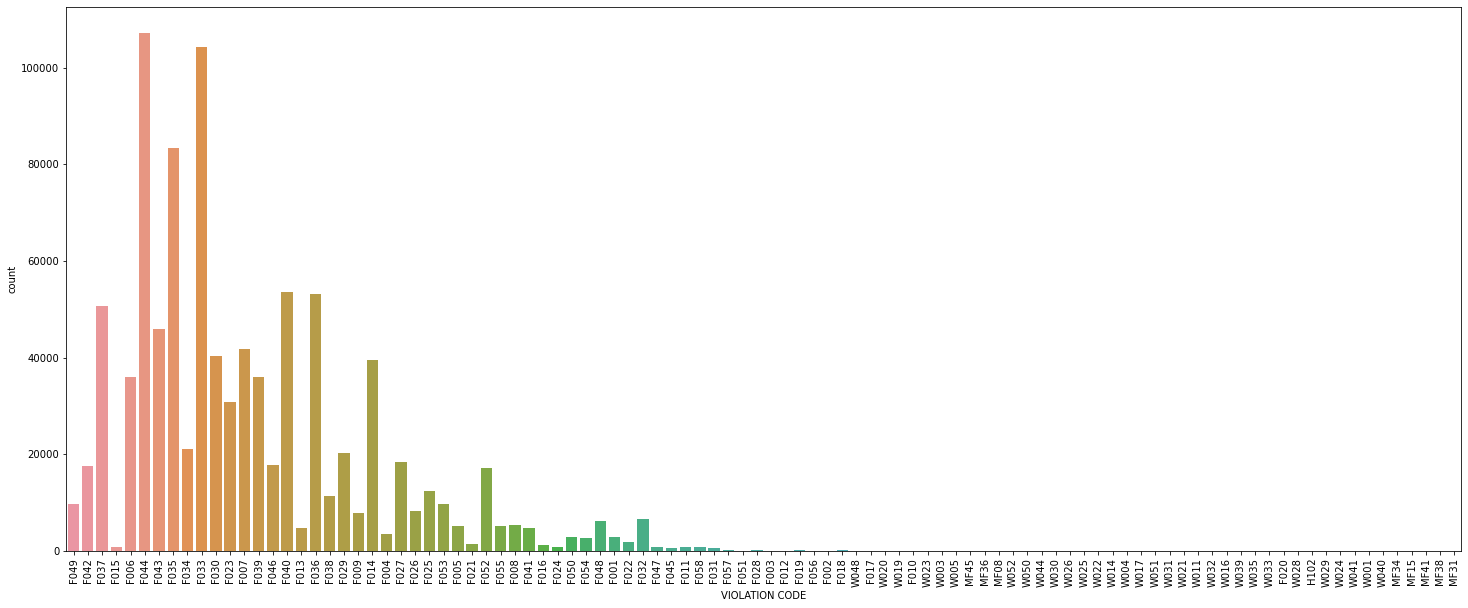

In [118]:
plt.figure(figsize=(25,10))
plt.xticks(rotation=90)
sns.countplot(x='VIOLATION CODE', data=viol)

## Checking for a correlation between Violations committed by vendor and their Zip Codes

In [119]:
#merging inspections and violations on SERIAL NUMBER 

merged_df = insp.merge(viol, how="left", on="SERIAL NUMBER")
merged_df.head()

,ACTIVITY DATE,OWNER ID,OWNER NAME,FACILITY ID,FACILITY NAME,RECORD ID,PROGRAM NAME,PROGRAM STATUS,PROGRAM ELEMENT (PE),PE DESCRIPTION,...,Location,2011 Supervisorial District Boundaries (Official),Census Tracts 2010,Board Approved Statistical Areas,Zip Codes,PE DESCRIPTION NEW,VIOLATION STATUS,VIOLATION CODE,VIOLATION DESCRIPTION,POINTS
0,2018-08-23,OW0000809,31,FA0019645,DREAM DINNERS,PR0045642,DREAM DINNERS,ACTIVE,1631,RESTAURANT SEATS MODERATE RISK,...,POINT (-118.36927 33.826754),4.0,820.0,102.0,25719.0,0-30,OUT OF COMPLIANCE,F048,# 47. Permits Available,1.0
1,2018-08-23,OW0000809,31,FA0019645,DREAM DINNERS,PR0045642,DREAM DINNERS,ACTIVE,1631,RESTAURANT SEATS MODERATE RISK,...,POINT (-118.36927 33.826754),4.0,820.0,102.0,25719.0,0-30,OUT OF COMPLIANCE,F046,# 46. Signs posted; last inspection report ava...,1.0
2,2018-08-23,OW0000809,31,FA0019645,DREAM DINNERS,PR0045642,DREAM DINNERS,ACTIVE,1631,RESTAURANT SEATS MODERATE RISK,...,POINT (-118.36927 33.826754),4.0,820.0,102.0,25719.0,0-30,OUT OF COMPLIANCE,F033,# 33. Nonfood-contact surfaces clean and in go...,1.0
3,2017-12-06,OW0000809,31,FA0019645,DREAM DINNERS,PR0045642,DREAM DINNERS,ACTIVE,1631,RESTAURANT SEATS MODERATE RISK,...,POINT (-118.36927 33.826754),4.0,820.0,102.0,25719.0,0-30,OUT OF COMPLIANCE,F048,# 47. Permits Available,1.0
4,2017-12-06,OW0000809,31,FA0019645,DREAM DINNERS,PR0045642,DREAM DINNERS,ACTIVE,1631,RESTAURANT SEATS MODERATE RISK,...,POINT (-118.36927 33.826754),4.0,820.0,102.0,25719.0,0-30,OUT OF COMPLIANCE,F044,"# 44. Floors, walls and ceilings: properly bui...",1.0


In [120]:
#creating a new dataframe from merged_df by grouping by Zip Codes and counting Violations per Zip Code

zip_group = pd.DataFrame(merged_df.groupby(by='Zip Codes', as_index=True).count()['VIOLATION CODE'])
zip_group.head()

,VIOLATION CODE
Zip Codes,
2443.0,1298
2445.0,2614
2447.0,5535
2451.0,911
2832.0,1933


In [121]:
#resetting index

zip_group.reset_index(inplace=True)
zip_group.head()

,Zip Codes,VIOLATION CODE
0,2443.0,1298
1,2445.0,2614
2,2447.0,5535
3,2451.0,911
4,2832.0,1933


In [122]:
#renaming columns 

zip_group.columns = ['Zip Code','Violations Committed']
zip_group.head()

,Zip Code,Violations Committed
0,2443.0,1298
1,2445.0,2614
2,2447.0,5535
3,2451.0,911
4,2832.0,1933


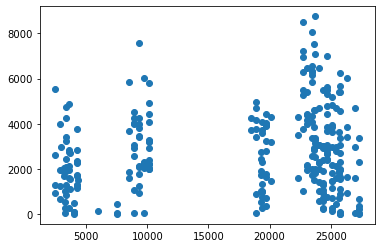

In [124]:
#plotting a scatter plot to check for correlation

x = zip_group['Zip Code']
y = zip_group['Violations Committed']

plt.scatter(x,y)

In [125]:
x.corr(y)

0.16960124611287977